### Тема: Машинное обучение в задачах обработки текстов на естественных языках
### Задача: Анализ тональности комментариев на площадка YouTube


In [3]:
import re
import time
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from pymystem3 import Mystem
from wordcloud import WordCloud

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, auc


In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### 1) Парсинг текстов комментариев

In [ ]:
options = webdriver.ChromeOptions()
options.add_argument('--ignore-certificate-errors')  # Игнорировать ошибки сертификата
options.add_argument('--ignore-ssl-errors')  # Игнорировать ошибки SSL

scrapped = []

with webdriver.Chrome(options=options) as driver:
    wait = WebDriverWait(driver, 5)
    driver.get('https://www.youtube.com/watch?v=lqRq1KBIe4c&ab_channel=%D0%92%D0%9F%D0%98%D0%A1%D0%9A%D0%90')

    for _ in tqdm(range(60)):  # 600 раз прокрутить страницу
        driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);")
        time.sleep(2)

    comments = wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, "#content")))
    for comment in comments:
        scrapped.append(comment.text)

In [ ]:
len(scrapped)

In [ ]:
comments = [x.split('\nОТВЕТИТЬ')[0].split('\n')[1] for x in scrapped[0].split('назад')][1:]

In [ ]:
len(scrapped[1:])

In [ ]:
comments = comments + scrapped[1:]

In [ ]:
for _ in range(5):
    print(comments[np.random.randint(len(comments))])

### 2) Обработка текстов комментариев, полученных с помощью парсинга

In [ ]:
comments_df =  pd.DataFrame({'comment':comments})

In [ ]:
comments_df.to_csv('comments_new.csv', index=False)

In [4]:
comments_df = pd.read_csv('comments_new.csv')

In [5]:
def clear_text(text: str) -> str:
    clear_text = re.sub(r'[^А-яЁё]+', ' ', text).lower()
    return ' '.join(clear_text.split())

def clean_stop_words(text: str, stopwords: list):
    cleaned_text = []
    for word in text.split():
        if word.lower() not in stopwords:
            cleaned_text.append(word)
    return " ".join(cleaned_text)

**Первая функция удаляет все символы, кроме русских букв и знаков препинания, приводя текст к нижнему регистру и удаляя лишние пробелы. Вторая функция удаляет из текста указанные стоп-слова, которые обычно не несут смысловой нагрузки.**

In [8]:
stopwords = set(nltk_stopwords.words('russian'))
np.array(stopwords)

array({'были', 'и', 'об', 'было', 'тот', 'тогда', 'много', 'опять', 'разве', 'чтоб', 'без', 'то', 'вдруг', 'нет', 'что', 'про', 'потом', 'была', 'как', 'хоть', 'сейчас', 'хорошо', 'него', 'перед', 'свою', 'во', 'да', 'был', 'нельзя', 'будет', 'здесь', 'ли', 'иногда', 'ему', 'никогда', 'этой', 'всего', 'один', 'за', 'лучше', 'от', 'я', 'надо', 'из', 'тем', 'с', 'после', 'чуть', 'где', 'бы', 'тоже', 'только', 'эти', 'со', 'впрочем', 'если', 'уже', 'зачем', 'того', 'вот', 'всегда', 'кто', 'есть', 'их', 'над', 'он', 'же', 'при', 'какая', 'о', 'тебя', 'другой', 'когда', 'этого', 'всех', 'конечно', 'под', 'потому', 'них', 'ним', 'вам', 'еще', 'мой', 'уж', 'тут', 'чем', 'три', 'нее', 'более', 'так', 'к', 'себя', 'ты', 'быть', 'ней', 'им', 'они', 'до', 'можно', 'раз', 'нас', 'все', 'ни', 'через', 'мы', 'или', 'себе', 'ну', 'совсем', 'вы', 'какой', 'а', 'почти', 'чтобы', 'наконец', 'сам', 'ж', 'нибудь', 'том', 'меня', 'теперь', 'даже', 'ничего', 'но', 'на', 'мне', 'будто', 'для', 'чего', 'она',

#### Пример работы функций

In [9]:
for comment in comments_df['comment'].head(5):
    text = comments_df.sample(n=1)['comment'].values[0][:100]
    print(text)
    print('------------------------')
    cleaned_text = clear_text(text)
    cleaned_text = clean_stop_words(cleaned_text, stopwords)
    print(cleaned_text)
    print()

Спасибо за откровенный разговор. Переживала вместе с Вами. Такие потери либо рушат судьбы, либо зака
------------------------
спасибо откровенный разговор переживала вместе вами такие потери либо рушат судьбы либо зака

Жизненно пиздец
------------------------
жизненно пиздец

а Зубареву - наиогромнейший респект! чувак реально сделал себя сам, не смотря на нелёгкую судьбу!
------------------------
зубареву наиогромнейший респект чувак реально сделал смотря нелёгкую судьбу

Панические атаки!!!!!!!! Это очень тяжело вывозить.. нас много?
------------------------
панические атаки это очень тяжело вывозить

Зубарев 
------------------------
зубарев



In [10]:
start_clean = time.time()
comments_df['cleared_text'] = comments_df['comment'].apply(lambda x: clean_stop_words(clear_text(str(x)), stopwords))

print(f'Обработка текста заняла {str(round(time.time() - start_clean, 2))} секунд')

Обработка текста заняла 0.18 секунд


### 3) Рассчитаем частность слов с помощтью bag of words

**Мешок слов - самая простая из всех существующих техник NLP. Она включает в себя три операции:**

**Токенизация**  
**Сначала входной текст разбивается на токены. Предложение представляется в виде списка его составляющих слов, и это делается для всех входных предложений.**

**Создание словаря**  
**Из всех полученных токенизированных слов выбираются только уникальные слова, которые затем сортируются в алфавитном порядке.**

**Создание вектора**  
**Наконец, из показателей частоты слов получившегося словаря создается разреженная матрица в качестве входных данных. В этой разреженной матрице каждая строка представляет вектор предложения, длина которого (количество столбцов в матрице) равна размеру словаря.**

In [11]:
comments_counter = CountVectorizer(ngram_range=(1,1))

In [12]:
count = comments_counter.fit_transform(comments_df['cleared_text'])

In [13]:
count.toarray().sum(axis=0).shape

(5294,)

In [14]:
comments_frequence = pd.DataFrame({
    'word': comments_counter.get_feature_names_out(),
    'frequency': count.toarray().sum(axis=0)
}).sort_values(by='frequency', ascending=False)

print(comments_frequence.shape[0])

5294


#### Сгенерируем красивые визуализации частотности слов

In [15]:
wordcloud_comments = WordCloud(
    background_color="black",
    colormap='Blues',
    max_words=200,
    mask=None,
    width=1600,
    height=1600
).generate_from_frequencies(dict(zip(comments_frequence['word'], comments_frequence['frequency'])))

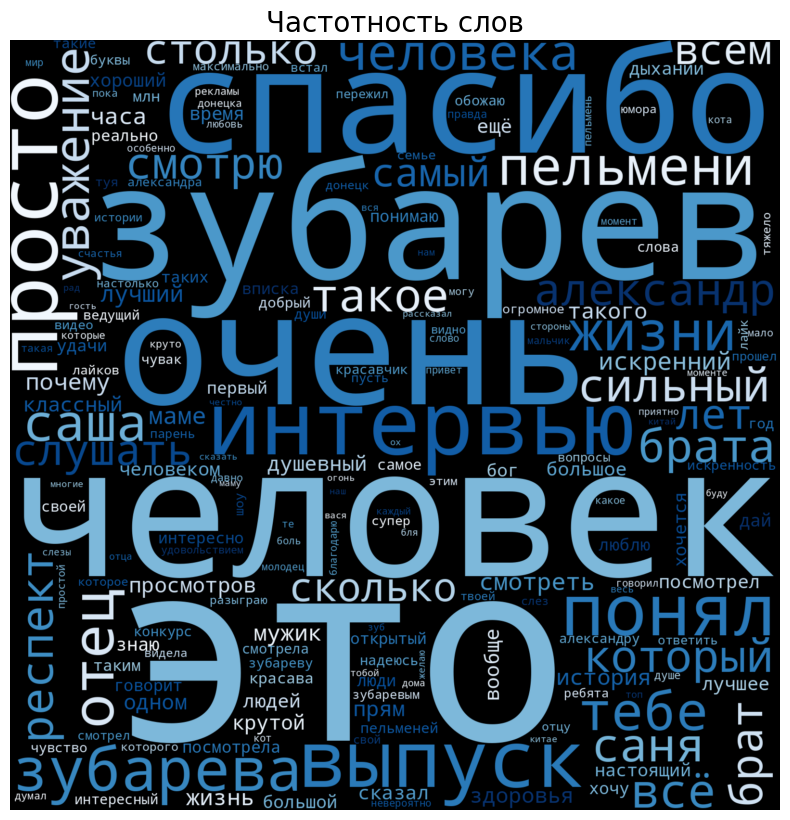

In [16]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
im = ax.imshow(wordcloud_comments, interpolation='bilinear')
ax.set_title('Частотность слов', fontsize=20)
ax.axis("off")
plt.show()

### 4) Загрузим датасет (RuTweetCorp), который используем для обучения модели

In [17]:
positive = pd.read_csv('positive.csv', sep=',', header=None,
                       dtype={'id': str, 'tdate': int, 'tname': str, 'ttext': str,
                              'ttype': int, 'trep': int, 'trtw': int, 'tfav': int, 'tstcount': int, 'tfoll': int},
                       low_memory=False)


In [18]:
negative = pd.read_csv('negative.csv', sep=',', header=None,
                       dtype={'id': str, 'tdate': int, 'tname': str, 'ttext': str,
                              'ttype': int, 'trep': int, 'trtw': int, 'tfav': int, 'tstcount': int, 'tfoll': int},
                       low_memory=False)

In [19]:
positive_text = pd.DataFrame(positive.iloc[:, 3])
negative_text = pd.DataFrame(negative.iloc[:, 3])

In [20]:
positive_text['label'] = [1] * positive_text.shape[0]
negative_text['label'] = [0] * negative_text.shape[0]

In [21]:
labeled_tweets = pd.concat([positive_text, negative_text])
labeled_tweets.index = range(labeled_tweets.shape[0])

In [22]:
labeled_tweets.columns = ['text', 'label']
labeled_tweets = labeled_tweets.iloc [1: , :]
labeled_tweets

text  label
1       @first_timee хоть я и школота, но поверь, у на...      1
2       Да, все-таки он немного похож на него. Но мой ...      1
3       RT @KatiaCheh: Ну ты идиотка) я испугалась за ...      1
4       RT @digger2912: "Кто то в углу сидит и погибае...      1
5       @irina_dyshkant Вот что значит страшилка :D\nН...      1
...                                                   ...    ...
226831  Но не каждый хочет что то исправлять:( http://...      0
226832  скучаю так :-( только @taaannyaaa вправляет мо...      0
226833          Вот и в школу, в говно это идти уже надо(      0
226834  RT @_Them__: @LisaBeroud Тауриэль, не грусти :...      0
226835  Такси везет меня на работу. Раздумываю приплат...      0

[226835 rows x 2 columns]

#### Теперь очистим наш размеченный датасет

In [23]:
start_clean = time.time()
labeled_tweets['text_clear'] = labeled_tweets['text'].apply(lambda x: clean_stop_words(clear_text(str(x)), stopwords))
print('Обработка текстов заняла: '+str(round(time.time() - start_clean, 2))+' секунд')

Обработка текстов заняла: 2.99 секунд


In [24]:
labeled_tweets = labeled_tweets[['text_clear', 'label']]
labeled_tweets

text_clear  label
1       школота поверь самое общество профилирующий пр...      1
2                        таки немного похож мальчик равно      1
3                                      идиотка испугалась      1
4       углу сидит погибает голода ещё порции взяли хо...      1
5       значит страшилка блин посмотрев части создастс...      1
...                                                   ...    ...
226831                            каждый хочет исправлять      0
226832                скучаю вправляет мозги равно скучаю      0
226833                               школу говно это идти      0
226834                              тауриэль грусти обнял      0
226835  такси везет работу раздумываю приплатить втащи...      0

[226835 rows x 2 columns]

In [25]:
labeled_tweets.isna().sum()

text_clear    0
label         0
dtype: int64

In [26]:
train, test = train_test_split(labeled_tweets, test_size = 0.2, random_state = 12348)

print(train.shape)
print(test.shape)

(181468, 2)
(45367, 2)


**Для обучения классификатора требуется преобразовать тексты в числовые представления. Качество классификации сильно зависит от метода преобразования текста в численные вектора. Один из таких методов - подсчет количества упоминаний каждого уникального слова в каждом тексте, что приводит к созданию мешков слов. Этот подход не учитывает порядок слов и использовался мною только для визуализации частотности слов.**

**Еще один метод, не учитывающий порядок слов, но более чувствительный к редким словам, - это TF-IDF. При использовании TF-IDF мы также получаем вектор длины, равной количеству уникальных слов, но сама оценка строится иначе: каждый компонент вектора формируется на основе двух факторов.**

**TF (Частота термина) обозначает, насколько часто определенное слово появляется в данном документе. Таким образом, TF измеряет важность слова в контексте отдельного документа.**

**$$TF = \dfrac{\text{Частотность термина в документе}}{\text{Общее количество слов в документе}}$$**

**IDF (Обратная частота документа) измеряет, насколько уникально слово является по всей коллекции документов. Слова, которые появляются в большинстве документов, имеют низкое IDF, так как они не вносят большой информационной ценности.**

**$$IDF = \log{\dfrac{\text{Общее количество документов}}{\text{количество документов со словом W}}}$$**


In [27]:
count_idf_positive = TfidfVectorizer(ngram_range = (1,1))
count_idf_negative = TfidfVectorizer(ngram_range = (1,1))

tf_idf_positive = count_idf_positive.fit_transform(train.query('label == 1')['text_clear'])
tf_idf_negative = count_idf_negative.fit_transform(train.query('label == 0')['text_clear'])

In [28]:
positive_importance = pd.DataFrame(
    {'word' : count_idf_positive.get_feature_names_out(),
     'idf' : count_idf_positive.idf_
    }).sort_values(by = 'idf', ascending = False)

negative_importance = pd.DataFrame(
    {'word' : count_idf_negative.get_feature_names_out(),
     'idf' : count_idf_negative.idf_
    }).sort_values(by = 'idf', ascending = False)

In [29]:
positive_importance.query('word not in @negative_importance.word and idf < 10')
#ставим ограничения на значения idf для того, чтобы нам не мешались слова, которые встречаются слишком редко и не имеют особого смысла

word       idf
25117    заботливый  9.943658
75858   реквестирую  9.943658
57766        очками  9.943658
79057     свободным  9.943658
63205     подсказал  9.943658
...             ...       ...
3364          ахаах  8.994578
93380      улыбнуло  8.714993
53385  оглядываются  8.667365
73634  разблокируют  8.644375
74496         ракал  7.584378

[110 rows x 2 columns]

In [30]:
negative_importance.query('word not in @positive_importance.word and idf < 9.5')

word       idf
35525                      мбх  9.458225
5491                    болить  9.458225
11616                   выпади  9.458225
9191                    внения  9.406932
75105                  терракт  9.358142
7783                     венки  9.358142
83072                   худший  9.358142
77555                  ублюдки  9.311622
33132                 линейные  9.311622
36644                  михаэль  9.311622
32100                   лагает  9.267170
83757                цымбаларь  9.224610
85924               шредингера  9.224610
34482                майкрофта  9.183788
55516                 порезала  9.183788
68189                скончался  9.183788
76238                    траур  9.070460
44995              однобокость  9.070460
20883                заболеваю  8.968677
86045                  шумахер  8.968677
44752                 огорчает  8.906157
27062               калашников  8.847316
19089                   ебанат  8.847316
29400                     коме  8.819145
68207                  скорбим  8.618474
41186                 некролог  8.377312
52345                 погибших  8.359613
62585                    рамка  8.359613
75029                   теракт  8.291790
69383  снаступающимтвиттерский  8.154169

### 5) Обучение моделей, сравнение, классификация комментариев

In [31]:
counter_idf = TfidfVectorizer(ngram_range=(1,1))

In [32]:
count_train = counter_idf.fit_transform(train['text_clear'])
count_test = counter_idf.transform(test['text_clear'])

In [33]:
train_subset = train[:100]
test_subset = test[:100]

# Применяем TF-IDF векторизацию к срезам данных
count_train_subset = counter_idf.transform(train_subset['text_clear'])
count_test_subset = counter_idf.transform(test_subset['text_clear'])

#логистическая регрессия
model_subset = LogisticRegression(solver='lbfgs', random_state=12345, max_iter=10000, n_jobs=-1)
model_subset.fit(count_train_subset, train_subset['label'])

#SVM
svm_model_subset = SVC(kernel='linear', random_state=12345)
svm_model_subset.fit(count_train_subset, train_subset['label'])

#случайный лес
rf_model = RandomForestClassifier(n_estimators=100, random_state=12345)
rf_model.fit(count_train_subset, train_subset['label'])

# Оцениваем обе модели на срезе тестовых данных
accuracy_logistic_regression = model_subset.score(count_test_subset, test_subset['label'])
accuracy_svm = svm_model_subset.score(count_test_subset, test_subset['label'])
accuracy_random_forest = rf_model.score(count_test_subset, test_subset['label'])

print("Точность логистической регрессии:", accuracy_logistic_regression)
print("Точность метода опорных векторов:", accuracy_svm)
print("Точность случайного леса:", accuracy_random_forest)

Точность логистической регрессии: 0.54
Точность метода опорных векторов: 0.54
Точность случайного леса: 0.52


**Видим, что из трёх моделей на небольшой выборке данных худшей оказалась random forest, оставим регрессию и метод опорных векторов**

**Увеличим выборку, чтобы разглядеть различия в точности моделей**

In [34]:
train_subset2 = train[:20000]
test_subset2 = test[:20000]

In [35]:
count_train_subset2 = counter_idf.transform(train_subset2['text_clear'])
count_test_subset2 = counter_idf.transform(test_subset2['text_clear'])

# Создаем и обучаем модель логистической регрессии на срезе данных
model_subset = LogisticRegression(solver='lbfgs', random_state=12345, max_iter=10000, n_jobs=-1)
model_subset.fit(count_train_subset2, train_subset2['label'])

svm_model_subset = SVC(kernel='linear', random_state=12345)
svm_model_subset.fit(count_train_subset2, train_subset2['label'])

# Оцениваем обе модели на срезе тестовых данных
accuracy_logistic_regression = model_subset.score(count_test_subset2, test_subset2['label'])
accuracy_svm = svm_model_subset.score(count_test_subset2, test_subset2['label'])

# print("Точность логистической регрессии:", accuracy_logistic_regression)
# print("Точность метода опорных векторов:", accuracy_svm)

predictions_logistic_regression = model_subset.predict(count_test_subset2)
predictions_svm = svm_model_subset.predict(count_test_subset2)

# Выводим classification report для логистической регрессии
print("Classification Report для логистической регрессии:")
print(classification_report(test_subset2['label'], predictions_logistic_regression))

# Выводим classification report для метода опорных векторов
print("Classification Report для метода опорных векторов:")
print(classification_report(test_subset2['label'], predictions_svm))

Classification Report для логистической регрессии:
              precision    recall  f1-score   support

           0       0.70      0.63      0.66      9870
           1       0.67      0.73      0.70     10130

    accuracy                           0.68     20000
   macro avg       0.68      0.68      0.68     20000
weighted avg       0.68      0.68      0.68     20000

Classification Report для метода опорных векторов:
              precision    recall  f1-score   support

           0       0.69      0.64      0.66      9870
           1       0.67      0.72      0.69     10130

    accuracy                           0.68     20000
   macro avg       0.68      0.68      0.68     20000
weighted avg       0.68      0.68      0.68     20000



**Можно сделать вывод, что на этих данных и с этими признаками обе модели работают примерно одинаково эффективно. Поэтому решающим фатором в выборе модели стала скорость обучения - модель логистической регрессии обучается намного быстрее**

In [36]:
model = LogisticRegression(solver = 'lbfgs', random_state = 12345, max_iter = 10000, n_jobs = -1)
model.fit(count_train, train['label'])
predict_count_proba = model.predict_proba(count_test)
accuracy_lregr = model.score(count_test, test['label'])

**Модель демонстрирует хорошие результаты на тестовых данных**

**Выведем веса слов, посмотрим - какие имеют наибольшую положительную и отрицательную окраску**

In [37]:
weights = pd.DataFrame({'words': counter_idf.get_feature_names_out(),
                        'weights': model.coef_.flatten()})
weights_min = weights.sort_values(by= 'weights')
weights_max = weights.sort_values(by= 'weights', ascending = False)

In [38]:
weights_max = weights_max[:20]
weights_max

words   weights
4824         ахаха  4.548650
4854        ахахах  4.360192
18324    вромайдан  4.343409
75718       обожаю  4.269854
4823          ахах  4.250757
100656     приятно  3.902943
139499        хаха  3.710405
109608         ржу  3.624646
35906      забавно  3.573029
120779     спасибо  3.435757
4855       ахахаха  3.403588
134715         ура  3.347119
91982   поздравляю  3.337125
139498         хах  3.323804
117864       смеха  3.303156
118281       снегу  3.239440
81230    отличного  3.187405
29905      доброго  3.153445
4877      ахахахах  3.133339
62875         мило  3.092008

In [39]:
weights_min = weights_min[:20]
weights_min['weights'] = weights_min['weights'] * -1
weights_min

words   weights
75096       обидно  6.903257
25406      грустно  6.221710
34355         жаль  6.038235
86945     печально  6.009928
34315        жалко  5.419977
119199   сожалению  5.364271
116726      скучаю  5.253387
86924       печаль  5.188953
10167         боль  5.032852
71321     ненавижу  4.812137
36106     заболела  4.617166
9174          блин  4.565137
132263         увы  4.498535
35162    жизньболь  4.486518
133028      ужасно  4.450846
133005        ужас  4.010950
133906        умер  3.997941
116715     скучать  3.995811
120559  сочувствую  3.902832
25419     грустный  3.824133

In [40]:
wordcloud_pos = WordCloud(
    background_color="white",
    colormap='Blues',
    max_words=200,
    mask=None,
    width=1600,
    height=1600
).generate_from_frequencies(dict(zip(weights_max['words'], weights_max['weights'])))

wordcloud_neg = WordCloud(
    background_color="black",
    colormap='Reds',
    max_words=200,
    mask=None,
    width=1600,
    height=1600
).generate_from_frequencies(dict(zip(weights_min['words'], weights_min['weights'])))


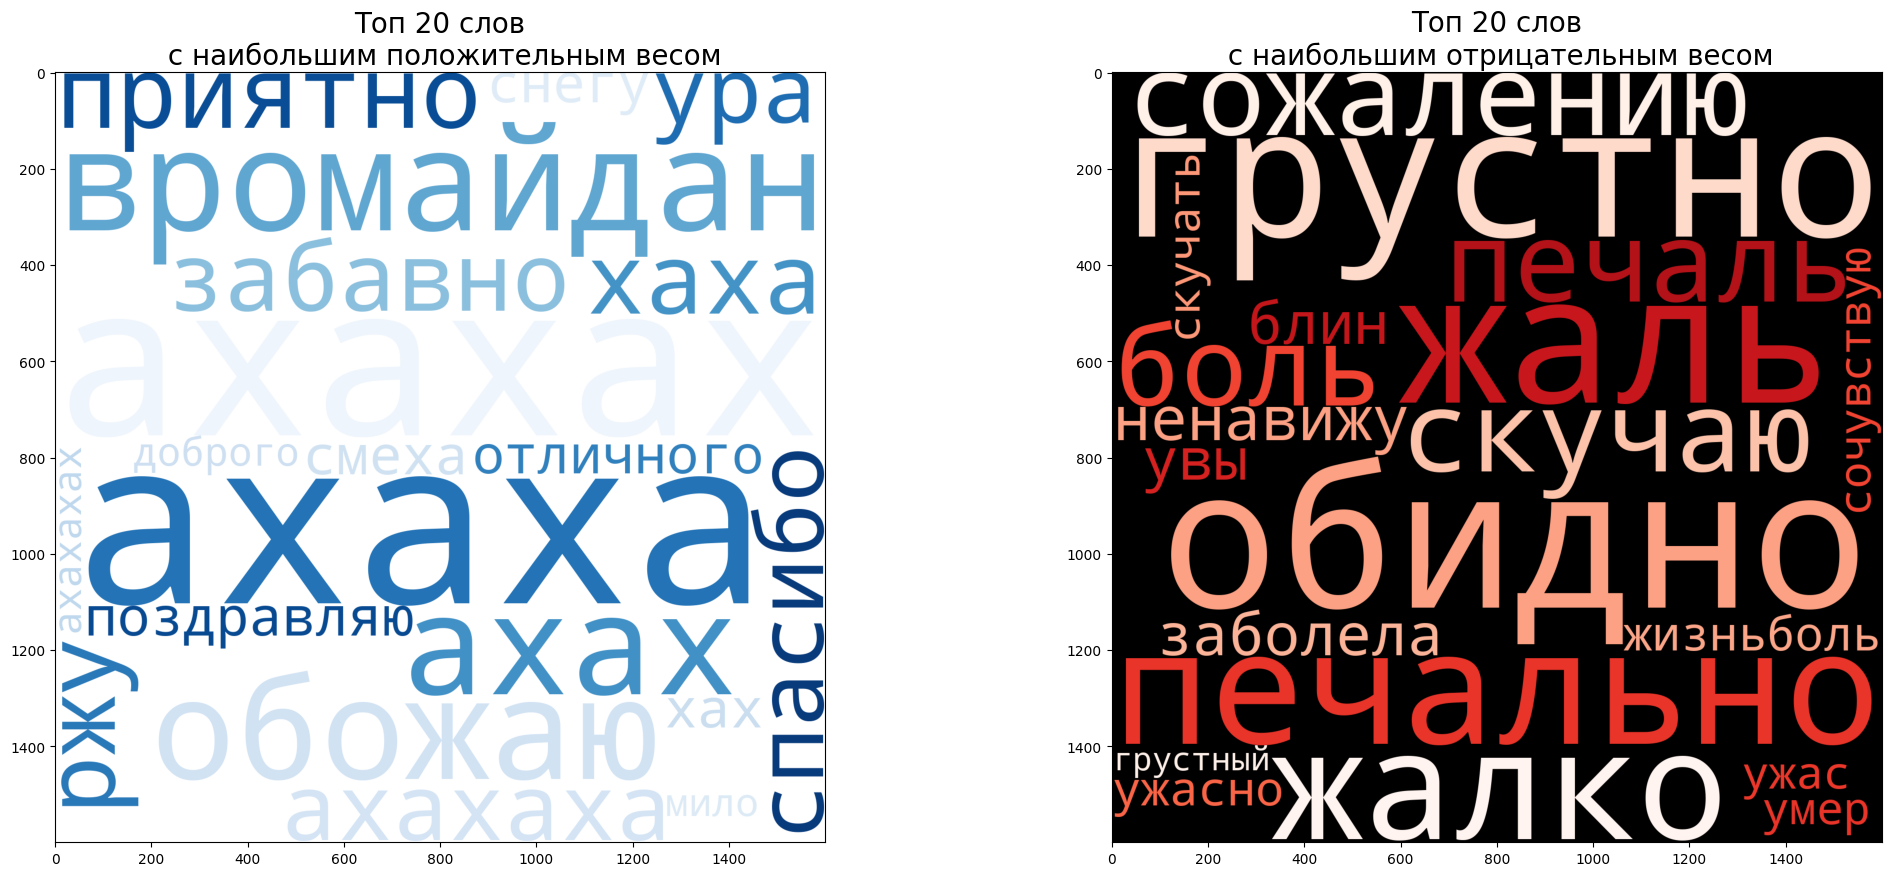

In [41]:
fig, ax = plt.subplots(1, 2, figsize = (25, 10))
ax[0].imshow(wordcloud_pos)
ax[1].imshow(wordcloud_neg)
ax[0].set_title('Топ 20 слов\n с наибольшим положительным весом',fontsize = 20)
ax[1].set_title('Топ 20 слов\n с наибольшим отрицательным весом',fontsize = 20)
plt.show()

### 6) Оценка качества классификации.

In [42]:
threshold = 0.5
predicted_labels = (predict_count_proba[:, 0] < threshold).astype('int')
true_labels = test['label']
matrix = confusion_matrix(true_labels, predicted_labels, normalize='true')

**В первой строке числа 0.697 и 0.303 указывают на то, что из тысячи негативных комментариев 697 были правильно идентифицированы, в то время как 303 были неправильно отнесены к позитивным. Во второй строке числа 0.232 и 0.767 означают, что из тысячи позитивных комментариев 232 ошибочно были отмечены как негативные.**

In [43]:
predicted_labels_t = model.predict(count_test)
predicted_probabilities_t = model.predict_proba(count_test)

In [44]:
accuracy_t = accuracy_score(test['label'], predicted_labels_t)
precision_t = precision_score(test['label'], predicted_labels_t)
recall_t = recall_score(test['label'], predicted_labels_t)
f1_t = f1_score(test['label'], predicted_labels_t)

In [45]:
print("Accuracy:", accuracy_t)
print("Precision:", precision_t)
print("Recall:", recall_t)
print("F1 Score:", f1_t)

Accuracy: 0.732823417902881
Precision: 0.7226519337016575
Recall: 0.767672376315103
F1 Score: 0.744482155279634


In [46]:
fpr_base, tpr_base, _ = roc_curve(test['label'], predict_count_proba[:, 1])
roc_auc_base = auc(fpr_base, tpr_base)

In [47]:
fig = make_subplots(1,1, subplot_titles = ["ROC"], x_title="False Positive Rate", y_title = "True Positive Rate")
fig.add_trace(go.Scatter(x = fpr_base, y = tpr_base, fill = 'tozeroy', name = "ROC base (area = %0.3f)" % roc_auc_base,))
fig.update_layout(
    height = 600,
    width = 800,
    xaxis_showgrid=False,
    xaxis_zeroline=False,
    )

**Модель демонстрирует приемлемую общую точность в 73.29%, с хорошей точностью и полнотой (72.27% и 76.78% соответственно). F1-мера составляет 74.46%, что указывает на сбалансированность между точностью и полнотой. В целом, модель показывает хорошие результаты**

In [48]:
fig = make_subplots(1,1)

fig.add_trace(go.Histogram(
    x = weights.query('weights != 0')['weights'],
    histnorm = 'probability',
    opacity = 0.5,
    showlegend = False
))

fig.add_trace(go.Histogram(
    x = weights.query('weights > 0.25 or weights < -0.25')['weights'],
    histnorm = 'probability',
    opacity = 0.5,
    showlegend = False
))

fig.update_layout(
    height = 600,
    width = 800,
    xaxis_showgrid=False,
    xaxis_zeroline=False,
)

**Можем заметить, что большинство слов имеют вес, близкий к 0. Очень маленькая часть слов превышает 0.5 по модулю. Поэтому предлагаю отсечь лишние слова, которые вряд ли сильно повлияют на модель, но уменьшат количество вычислений**

In [49]:
vocab = weights.query('weights > 0.25 or weights < -0.25')['words']

In [50]:
vocab

0                аа
1               ааа
2              аааа
3             ааааа
4            аааааа
            ...    
150080        ёхууу
150085          ёще
150088    ёёлочкууу
150089       ёёпрст
150094         ёёёё
Name: words, Length: 48628, dtype: object

**Получим векторные представления**

In [51]:
count_idf = TfidfVectorizer(vocabulary=vocab,
                            ngram_range=(1,1))

In [52]:
tf_idf_train = count_idf.fit_transform(train['text_clear'])
tf_idf_test = count_idf.transform(test['text_clear'])

In [53]:
display(tf_idf_test.shape)
display(tf_idf_train.shape)

(45367, 48628)

(181468, 48628)

**Строим новую модель после уменьшения размерности**

In [54]:
model_lr = LogisticRegression(solver = 'lbfgs', random_state = 12345, max_iter= 10000, n_jobs= -1)

In [55]:
model_lr.fit(tf_idf_train, train['label'])

LogisticRegression(max_iter=10000, n_jobs=-1, random_state=12345)

In [56]:
predictions = model_lr.predict(tf_idf_test)

In [57]:
accuracy_lr = accuracy_score(test['label'], predictions)
precision_lr = precision_score(test['label'], predictions)
recall_lr = recall_score(test['label'], predictions)
f1_lr = f1_score(test['label'], predictions)

In [58]:
print("Accuracy:", accuracy_lr)
print("Precision:", precision_lr)
print("Recall:", recall_lr)
print("F1 Score:", f1_lr)

Accuracy: 0.7320519320210725
Precision: 0.7244619205298013
Recall: 0.7609338318407095
F1 Score: 0.7422501166193122


**После уменьшения размерности векторов модель показала следующие изменения в метриках:**

**- Accuracy уменьшилась с примерно 73.29% до 73.21%, что указывает на небольшое снижение общей точности модели.**  
**- Precision увеличилась с примерно 72.27% до 72.46%, что означает, что модель стала более точной в предсказании положительных классов.**  
**- Recall уменьшилась с примерно 76.78% до 76.09%, что указывает на небольшое снижение способности модели идентифицировать все действительные положительные объекты.**  
**- F1 Score уменьшилась примерно 74.46% до 74.23%, что говорит о небольшом снижении сбалансированности между точностью и полнокторов.**

In [59]:
predict_count_proba = model_lr.predict_proba(tf_idf_test)

In [60]:
fpr_base_1, tpr_base_1, _ = roc_curve(test['label'], predict_count_proba[:, 1])
roc_auc_base_1 = auc(fpr_base_1, tpr_base_1)

In [61]:
fig = make_subplots(1,1,
                    subplot_titles = ["ROC"],
                    x_title="Ложноположительные",
                    y_title = "Истинноположительные"
                   )

fig.add_trace(go.Scatter(
    x = fpr_base,
    y = tpr_base,
    fill = 'tozeroy',
    name = "Кривая ROC (площадь = %0.3f)" % roc_auc_base,
    ))

fig.add_trace(go.Scatter(
    x = fpr_base_1,
    y = tpr_base_1,
    fill = 'tozeroy',
    name = "Кривая ROC с меньшей плотностью (площадь = %0.3f)" % roc_auc_base_1,
    ))


fig.update_layout(
    height = 600,
    width = 800,
    xaxis_showgrid=False,
    xaxis_zeroline=False,
    )

**Удалось снизить размерность векторов tf-idf потеряв при этом 0.2% качества (площадь под ROC кривой при размерности > 170К 0.809, площадь под ROC кривой при размерности > 48K -- 0.807)**

### 7) Классификация комментариев

In [62]:
for i in range(3):
    source = comments_df.sample(n=1)
    text_clear = source['cleared_text'].values[0]
    text = source['comment'].values[0]
    print(text)
    tf_idf_text = count_idf.transform([text_clear])
    toxic_proba = model_lr.predict_proba(tf_idf_text)
    print(f'Вероятность негатива: {toxic_proba[0][0]:.4f}')
    print()

Я никогда не писал комментарии на Ютубе, но этот выпуск просто настолько живой, настолько настоящий. Александр! Гхолова! Ты очень крутой. Спасибо за искренность и открытость. Человечище
Вероятность негатива: 0.0926

как только стал хвастать часами....фу... отписка..
Вероятность негатива: 0.7009

Зубарев классный !
Вероятность негатива: 0.2546



In [63]:
for i in range(3):
    source = comments_df.sample(n=1)
    text_clear = source['cleared_text'].values[0]
    text = source['comment'].values[0]
    print(text)
    tf_idf_text = count_idf.transform([text_clear])
    good_proba = model_lr.predict_proba(tf_idf_text)
    print(f'Вероятность позитива: {good_proba[0][1]:.4f}')
    print()

Бож, это шедевр! Батя, огонь 
,булочка лучшая 
Вероятность позитива: 0.8507

Где жопа в тепле там и хорошо!!! Молодец все жизненно!
Вероятность позитива: 0.5864

Ну Зубарев, он реально настоящий, он не играет роль, он такой и есть. Классный выпуск с отличным человеком
Вероятность позитива: 0.9076



#### Построим график отношения положительных комментариев к отрицательным

In [64]:
comments_tf_idf = count_idf.transform(comments_df['cleared_text'])

In [65]:
comments_probability = model_lr.predict_proba(comments_tf_idf)

In [66]:
comments_df['positive_proba'] = comments_probability[:, 0]
comments_df['negative_proba'] = comments_probability[:, 1]

In [67]:
#доля положительных комментариев
comment_pos_dolya = (comments_df['positive_proba'] > 0.45).sum() / comments_df.shape[0]
comment_pos_dolya

0.3886838868388684

In [68]:
#доля негативных комментариев
comments_neg_dolya = (comments_df['negative_proba'] > 0.55).sum() / comments_df.shape[0]
comments_neg_dolya

0.6113161131611317

In [69]:
fig = make_subplots(rows=1, cols=2, subplot_titles=['Распределение негативных комментариев', 'Распределение положительных комментариев'])

fig.add_trace(go.Violin(
    x=comments_df['negative_proba'],
    meanline_visible=True,
    name='Негативные (N = %i)' % comments_df.shape[0],
    side='positive',
    spanmode='hard'
), row=1, col=1)

fig.add_trace(go.Violin(
    x=comments_df['positive_proba'],
    meanline_visible=True,
    name='Положительные (N = %i)' % comments_df.shape[0],
    side='positive',
    spanmode='hard'
), row=1, col=2)

fig.add_annotation(x=0.44, y=1, text="%0.2f — доля негативных комментариев (при p > 0.55)" % comments_neg_dolya,
                   showarrow=False, yshift=10, row = 1, col = 2)
fig.add_annotation(x=0.52, y=1, text="%0.2f — доля положительных комментариев (при p > 0.45)" % comment_pos_dolya,
                   showarrow=False, yshift=10)

fig.update_traces(orientation='h', width=1.5, points=False)

fig.update_layout(height=500, xaxis_zeroline=False, legend=dict(y=0.9, x=-0.1, yanchor='top'))

fig.update_yaxes(visible=False)
fig.show()

**На графике выше мы можем наблюдать сравнение распределений комментариев к видеороликам. Пунктирной линией отмечено медианное значение, которое разделяет выборку на две равные части.**

**Чтобы улучшить модель, можно собрать сотни тысяч комментариев. Затем, используя обученный классификатор, оценить неразмеченные комментарии и отобрать только те, в которых классификатор выражает высокую уверенность. Эти комментарии нужно будет добавить в список размеченных, получить их векторные представления и повторно обучить модель. Такую итерацию повторить несколько раз для дополнительного улучшения модели.**